In [11]:
import numpy as np
import matplotlib.pyplot as plt

## Smoothing COVID data

So we'll see how a convolution works on real data.
We'll get the latest mortality figures from **GitHub**.

The [source](https://github.com/CSSEGISandData/COVID-19) is maintained by John Hopkins University.


In [1]:
! ../.g
country = 258

[master 4060cea] web
 1 file changed, 30 insertions(+), 30 deletions(-)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 782 bytes | 782.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   4e09048..4060cea  master -> master


In [2]:
import requests
import pandas as pd

In [518]:
root_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
fn = 'time_series_covid19_%s_global.csv'

for ss in ['deaths','confirmed']:
    r = requests.get(root_dir + fn%ss, allow_redirects=True)
    open('covid_%s.csv'%ss, 'wb').write(r.content)

## Visualising the data again

We'll convert to a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

- If you want to know more [read this in french](http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Data_Manipulation_Pandas.pdf).
- It's basically a table like in Excel
    - columns have names
    - rows are numbered and accessed using ```iloc```.


In [81]:
df = pd.read_csv('covid_deaths.csv')

---

## List the countries with > 10000 dead

In [82]:
 df[ df.iloc[:,-1] > 10000 ].iloc[:,[1,-1]]

,Country/Region,11/14/20
6,Argentina,35307
23,Belgium,14303
30,Brazil,165658
55,Chile,14777
89,Colombia,33829
106,Ecuador,12997
126,France,42215
130,Germany,12511
143,India,129635
144,Indonesia,15148


In [6]:
country = 258
df.iloc[country]

Province/State               NaN
Country/Region    United Kingdom
Lat                      55.3781
Long                      -3.436
1/22/20                        0
                       ...      
11/10/20                   49770
11/11/20                   50365
11/12/20                   50928
11/13/20                   51304
11/14/20                   51766
Name: 258, Length: 302, dtype: object

---

It's often easier to work with a numpy array of values

In [9]:
deaths = df.iloc[country][4:].values
deaths[-1]

51766

# Cumulative deaths

this looks pretty smooth

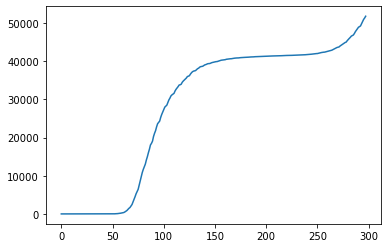

In [12]:
plt.plot(deaths);

Use ```np.diff``` to get daily death figures.

This is like differentiating the cumulative numbers.

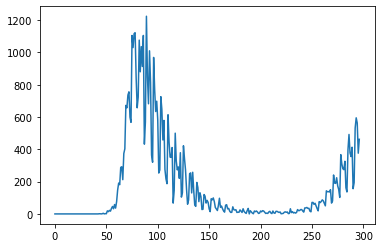

In [13]:
daily = np.diff(deaths,1)
plt.plot(daily);

Lets's look at the second wave

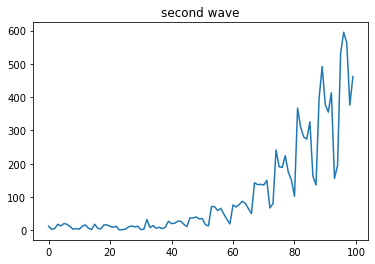

In [15]:
plt.plot(daily[-100:])
plt.title('second wave');

---

## Weekdays

The data is not too noisy compared with France.


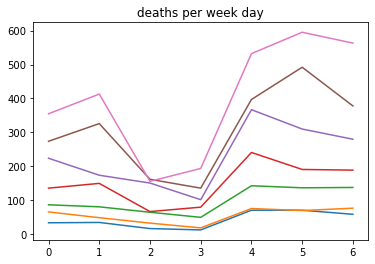

In [16]:
weeks = daily[-51:-2].reshape((-1,7))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per week day');

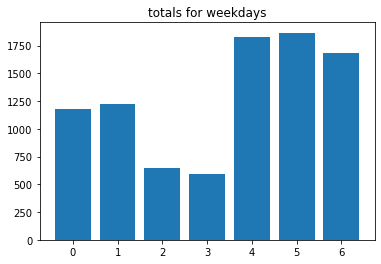

In [17]:
plt.bar(np.arange(7), np.sum(weeks, axis=0))
#plt.plot(np.sum(weeks, axis=0))
plt.title('totals for weekdays');

## Smoothing



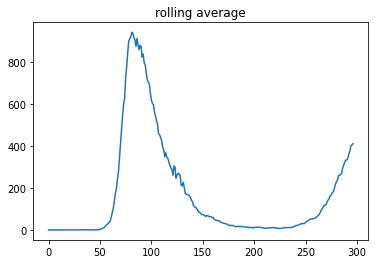

In [19]:
smooth_deaths = np.convolve(daily, np.ones(7)/7)[:-6]

plt.plot( smooth_deaths)
plt.title('rolling average');

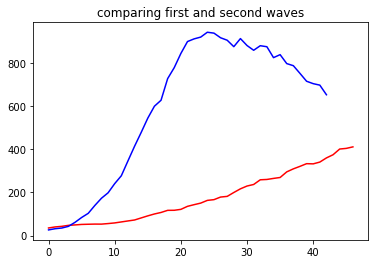

In [67]:
plt.plot(smooth_deaths[250:],'r')
plt.plot(smooth_deaths[57:100],'b');
plt.title('comparing first and second waves');

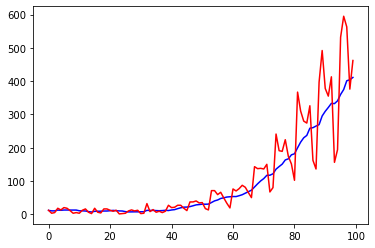

In [26]:
plt.plot(smooth_deaths[-100:],'b');
plt.plot(daily[-100:],'r');

---

## Kind of dumb but..

This is a heat map of the rvalue
to see where the fit is best.

<ipython-input-29-d4be8000462d>:3: RuntimeWarning: divide by zero encountered in log
  YY = np.log(smooth_deaths.tolist())


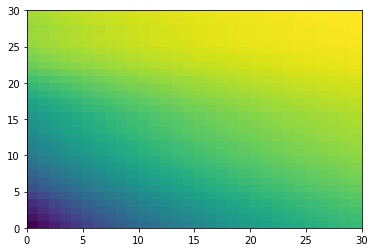

In [29]:
from scipy import stats
M = np.zeros((30,30))
YY = np.log(smooth_deaths.tolist())

for i, x in enumerate(range(185,215)):
    for j, y in enumerate(range(265,295)):
        Y = YY[x:y]
        X = np.arange(y-x)
        M[i,j] = stats.linregress(X,Y).rvalue
        
        
plt.pcolor(M)
plt.show()

# Exponential  growth in deaths ?

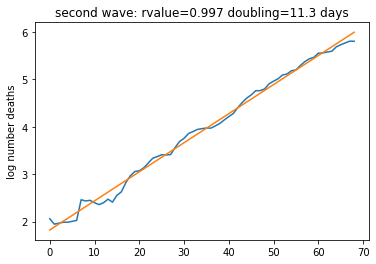

In [72]:
from scipy import stats

def regression_gph(Y, label='wave'):


    X = np.arange(len(Y))

    #plot raw data
    plt.plot(X,Y);

    #do regression
    coeffs = stats.linregress(X,Y)
    a,b = coeffs.slope, coeffs.intercept

    #plot regression curve
    plt.plot( X[[0,-1]], a*X[[0,-1]] + b)
    plt.title('{}: rvalue={:.3f} doubling={:.1f} days'.format(label ,coeffs.rvalue, np.log(2)/a) )
    plt.ylabel('log number deaths')
    
Y =  np.log(smooth_deaths[222:-6].tolist())
regression_gph(Y, label='second wave')
    
    

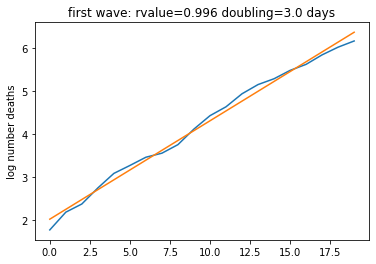

In [76]:
Y =  np.log(smooth_deaths[52:72].tolist())
regression_gph(Y, label='first wave')

---

## That's great!!


The [doubling time](https://en.wikipedia.org/wiki/Doubling_time)
for the second wave is about 11 days !

For the first wave it was 3 days.



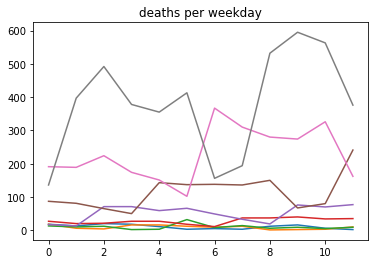

In [40]:
weeks = daily[200:-1].reshape((-1,12))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per weekday');

---

## Confirmed cases

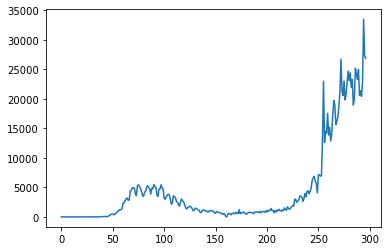

In [137]:
ddf = pd.read_csv('covid_confirmed.csv')

cases =  ddf.iloc[country][4:].values
daily = np.diff(cases, 1)
plt.plot(daily);

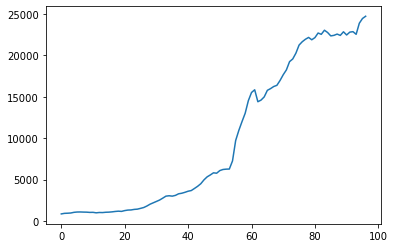

In [138]:
smoothed_cases = np.convolve(daily, np.ones(7)/7)[:-6]
plt.plot(smoothed_cases[200:]);

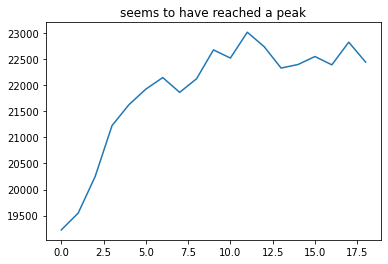

In [139]:
plt.plot(smoothed_cases[-25:-6]);
plt.title('seems to have reached a peak');

In [141]:
Y = np.log(smoothed_cases[210:273].tolist()
regression_gph(Y, label='2nd wave')

plt.ylabel('log number cases');

TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable log method

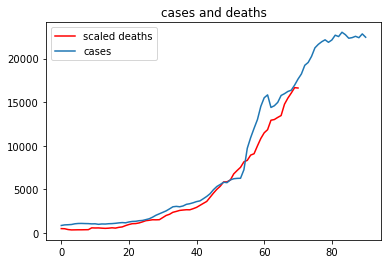

In [101]:
plt.plot( 50*smooth_deaths[220:-6],'r',label='scaled deaths')
plt.plot(smoothed_cases[200:-6],label='cases')
plt.title('cases and deaths')
plt.legend();

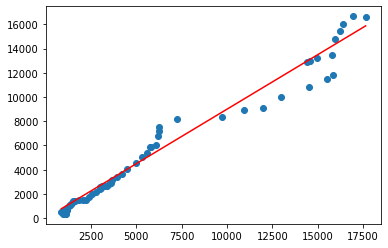

In [133]:
D = 50*smooth_deaths[220:-6]
C = smoothed_cases[200:200+len(D)]

S = stats.linregress( C.tolist(), D.tolist())
a, B = S.slope, S.intercept

plt.scatter(C,D)
plt.plot( C[[0,-1]], a*C[[0,-1]] + b,'r');


# Mortality rate for the second wave

In [78]:
(deaths[-1] - deaths[210])/ (cases[-1] - cases[210])

0.010133319260636126

In [666]:
M = np.zeros((20,20))
YY = np.log(smoothed.tolist())

for i, x in enumerate(range(200,220)):
    for j, y in enumerate(range(270,290)):
        Y = YY[x:y]
        X = np.arange(y-x)
        M[i,j] = stats.linregress(X,Y).rvalue

<ipython-input-666-49efe0b4dab3>:2: RuntimeWarning: divide by zero encountered in log
  YY = np.log(smoothed.tolist())


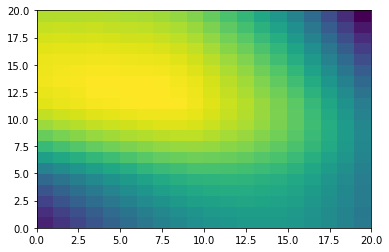

In [678]:
plt.pcolor(M)
plt.show()

In [134]:
! ../.g 

[master a3d09c8] web
 1 file changed, 91 insertions(+), 64 deletions(-)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 27.23 KiB | 929.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   7483e79..a3d09c8  master -> master
